<a href="https://colab.research.google.com/github/GiorgioMerolla/AI-Italy-Covid-19/blob/master/Italy_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Italy Covid-19


*   Autore: Giorgio Merolla
*   Contact: giorgio.merolla@gmail.com
*   GitHub: https://github.com/GiorgioMerolla
*   Linkedin: https://www.linkedin.com/in/giorgio-merolla/





In [0]:
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML
import matplotlib.pyplot as plt

In [0]:
# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [0]:
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

In [0]:
dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [5]:
df_table = (pd.DataFrame(dict(Cases=dfc_cases, Deaths=dfc_deaths, PCases=dfp_cases, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.head(15)

,Country/Region,Cases,Deaths,PCases,PDeaths,Cases (+),Deaths (+),Fatality Rate,Continent
0,US,699706,36773,555313,22019,144393,14754,5.3,North America
1,Spain,190839,20002,166831,17209,24008,2793,10.5,Europe
2,Italy,172434,22745,156363,19899,16071,2846,13.2,Europe
3,France,149130,18703,121712,14412,27418,4291,12.5,Europe
4,Germany,141397,4352,127854,3022,13543,1330,3.1,Europe
5,United Kingdom,109769,14607,85206,10629,24563,3978,13.3,Europe
6,China,83760,4636,83134,3343,626,1293,5.5,Asia
7,Iran,79494,4958,71686,4474,7808,484,6.2,Asia
8,Turkey,78546,1769,56956,1198,21590,571,2.3,Asia
9,Belgium,36138,5163,29647,3600,6491,1563,14.3,Europe


In [6]:
# Focus ITA
metrics = ['Cases', 'Deaths', 'Cases (+)', 'Deaths (+)']
s_ita = df_table[df_table['Country/Region'].eq('Italy')][metrics].sum().add_prefix('ITA ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**s_ita}
summary

{'ITA Cases': 172434,
 'ITA Cases (+)': 16071,
 'ITA Deaths': 22745,
 'ITA Deaths (+)': 2846}

In [7]:
# DF of new cases
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,2,0,0,4,5,5,1,0,0,2,0,16,0,34,10,10,16,0,10,50,4,63,36,8,18,50,18,56,21,40,37,34,52,58,49,70,56,66
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,8,2,11,10,5,4,9,4,4,5,6,6,13,15,19,23,28,12,11,15,11,20,16,18,27,29,28,16,6,17,9,7,17,13,21,8,19,24,21
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,4,2,11,11,6,6,14,13,3,49,62,29,34,38,65,42,45,57,73,132,131,139,185,80,69,103,45,104,94,95,64,89,69,87,90,108,150
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,37,0,14,22,13,25,20,31,24,36,43,41,26,36,6,14,38,11,27,35,24,20,19,19,18,0,37,8,13,14,0,23
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,2,0,0,1,0,0,2,4,2,1,2,0,0,0,0,0,0,0,0,0


In [8]:
dft_ct_new_cases.columns

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15

# AI Forecasting
Using the Machine Learning for Covid-19, use the library Prophet, from: https://facebook.github.io/prophet/ to predict the new cases & deaths in Italy

In [9]:
df_ita_1 = dft_ct_new_cases.T

df_ita = pd.DataFrame(df_ita_1['Italy'])
df_ita['data'] = dft_ct_new_cases.columns
print(df_ita)

         Italy     data
1/22/20      0  1/22/20
1/23/20      0  1/23/20
1/24/20      0  1/24/20
1/25/20      0  1/25/20
1/26/20      0  1/26/20
...        ...      ...
4/13/20   3153  4/13/20
4/14/20   2972  4/14/20
4/15/20   2667  4/15/20
4/16/20   3786  4/16/20
4/17/20   3493  4/17/20

[87 rows x 2 columns]


In [0]:
df_ita.columns = ['y', 'ds']

In [11]:
from fbprophet import Prophet as pp
m = pp()
m.fit(df_ita)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=20, freq='D')
future.tail()

,ds
102,2020-05-03
103,2020-05-04
104,2020-05-05
105,2020-05-06
106,2020-05-07


In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
102,2020-05-03,6366.992504,4988.301299,7999.468099
103,2020-05-04,6042.289927,4379.051223,7559.070264
104,2020-05-05,5986.983966,4450.378150,7413.087681
105,2020-05-06,6367.395940,4731.427441,7836.129703
106,2020-05-07,6476.861555,4915.813106,8021.888534


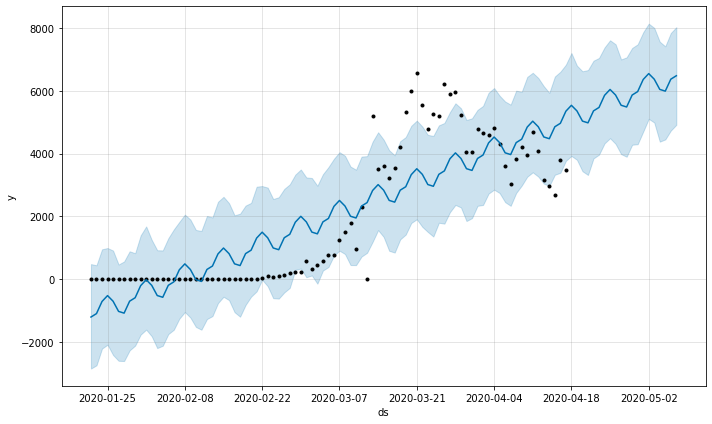

In [14]:
fig1 = m.plot(forecast)

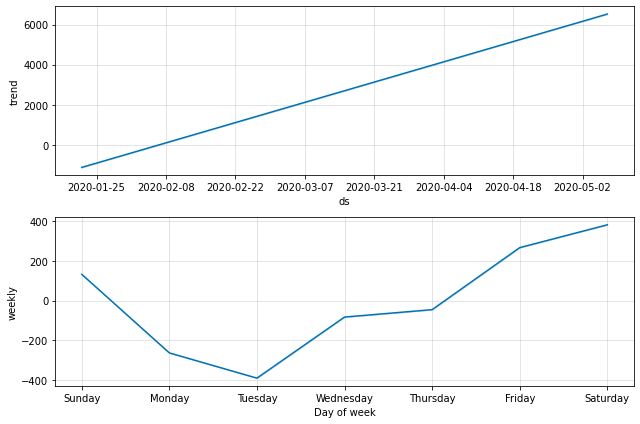

In [15]:
fig2 = m.plot_components(forecast)

In [16]:
# DF of new death
dft_ct_deaths = dft_deaths.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_deaths = dft_ct_deaths.diff(axis=1).fillna(0).astype(int)
dft_ct_new_deaths.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,2,0,1,0,4,3,0,1,0,3,0,3,2,2,5,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,1,0,1,2,2,0,1,4,0,1,1,3,0,1,1,0,1,0,0,0,0,1,1,1,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,3,2,2,4,2,0,2,2,4,1,3,2,4,9,14,28,19,25,22,21,20,12,30,21,19,18,20,13,10,12,16
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,3,2,4,2,1,1,1,1,3,1,1,2,1,0,3,0,2,2,0,2
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df_ita_2 = dft_ct_new_deaths.T

df_ita_deaths = pd.DataFrame(df_ita_2['Italy'])
df_ita_deaths['data'] = dft_ct_new_deaths.columns
print(df_ita_deaths)

         Italy     data
1/22/20      0  1/22/20
1/23/20      0  1/23/20
1/24/20      0  1/24/20
1/25/20      0  1/25/20
1/26/20      0  1/26/20
...        ...      ...
4/13/20    566  4/13/20
4/14/20    602  4/14/20
4/15/20    578  4/15/20
4/16/20    525  4/16/20
4/17/20    575  4/17/20

[87 rows x 2 columns]


In [18]:
df_ita_deaths.columns = ['y', 'ds']
from fbprophet import Prophet as pp
m = pp()
m.fit(df_ita_deaths)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
102,2020-05-03,862.014362,654.036736,1085.120881
103,2020-05-04,879.776945,672.240161,1102.728541
104,2020-05-05,900.292982,686.203610,1133.505484
105,2020-05-06,908.049065,706.965292,1102.654807
106,2020-05-07,896.407234,689.896489,1120.134915


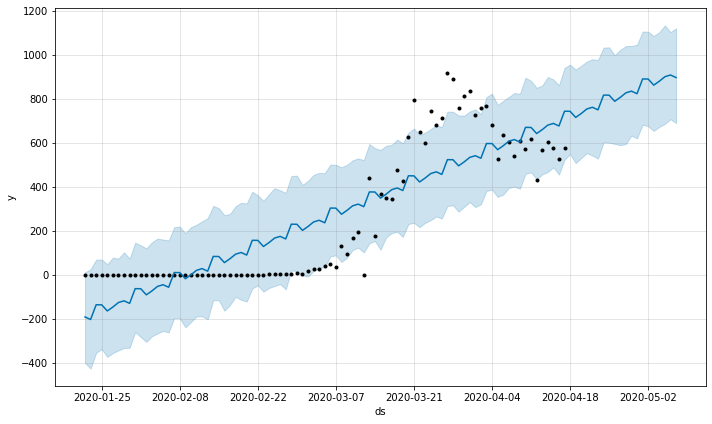

In [20]:
fig1 = m.plot(forecast)

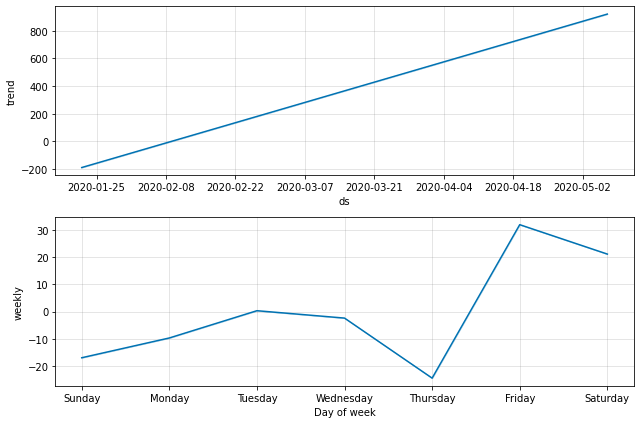

In [21]:
fig2 = m.plot_components(forecast)

# Logistic Modeling for Covid-19

In [22]:
Italy_Data = pd.DataFrame(df_ita_2['Italy'])
Italy_Data['Cases'] = df_ita_1['Italy']
Italy_Data.columns = ['Deaths', 'Confirmed Cases']
Italy_Data

,Deaths,Confirmed Cases
1/22/20,0,0
1/23/20,0,0
1/24/20,0,0
1/25/20,0,0
1/26/20,0,0
...,...,...
4/13/20,566,3153
4/14/20,602,2972
4/15/20,578,2667
4/16/20,525,3786


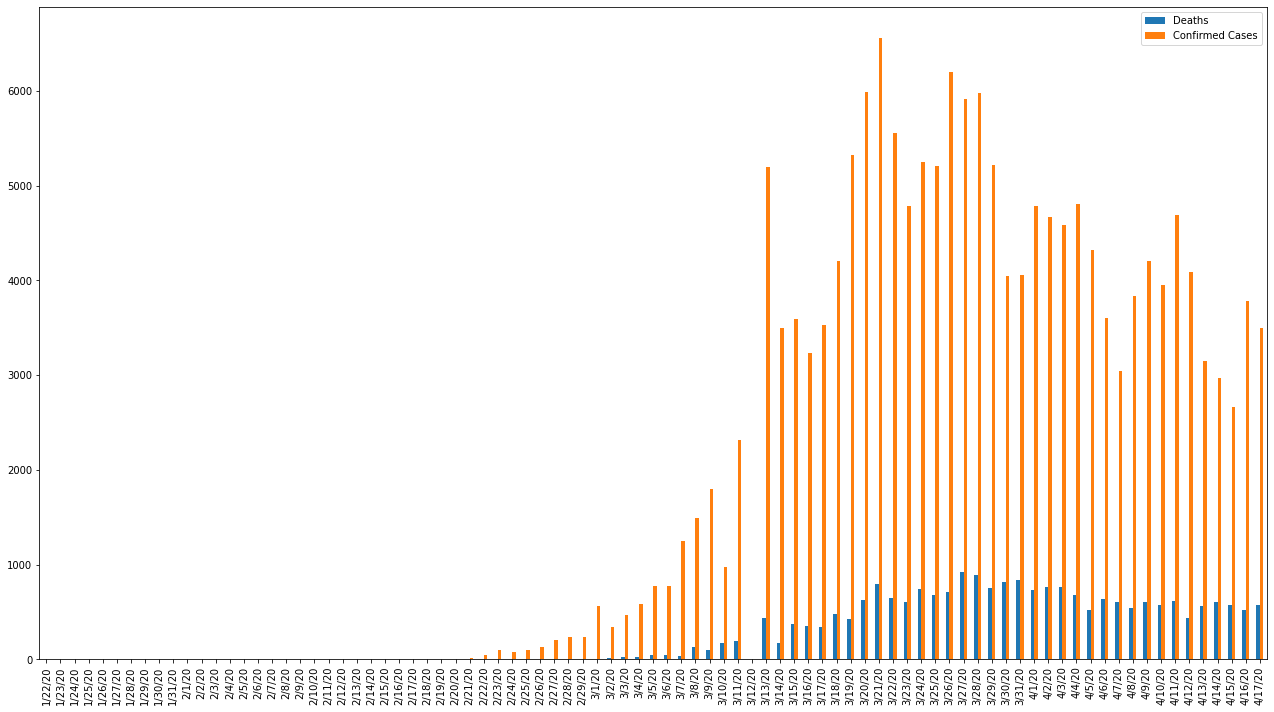

In [23]:
Italy_Data.plot(kind='bar', figsize=(22, 12))

In [24]:
import math
import numpy as np
from scipy import optimize

def logistic_function(x: float, a: float, b: float, c: float):
    ''' 1 / (1 + e^-x) '''
    return a / (1.0 + np.exp(-b * (x - c)))

X, y = list(range(len(Italy_Data))), Italy_Data['Confirmed Cases'].tolist()
# Providing a reasonable initial guess is crucial for this model
params, _ = optimize.curve_fit(logistic_function, X, y, p0=[max(y), 1, np.median(X)])

print('Estimated function: {0:.3f} / (1 + e^({1:.3f} * (X - {2:.3f}))'.format(*params))

Estimated function: 4530.973 / (1 + e^(0.387 * (X - 49.065))


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


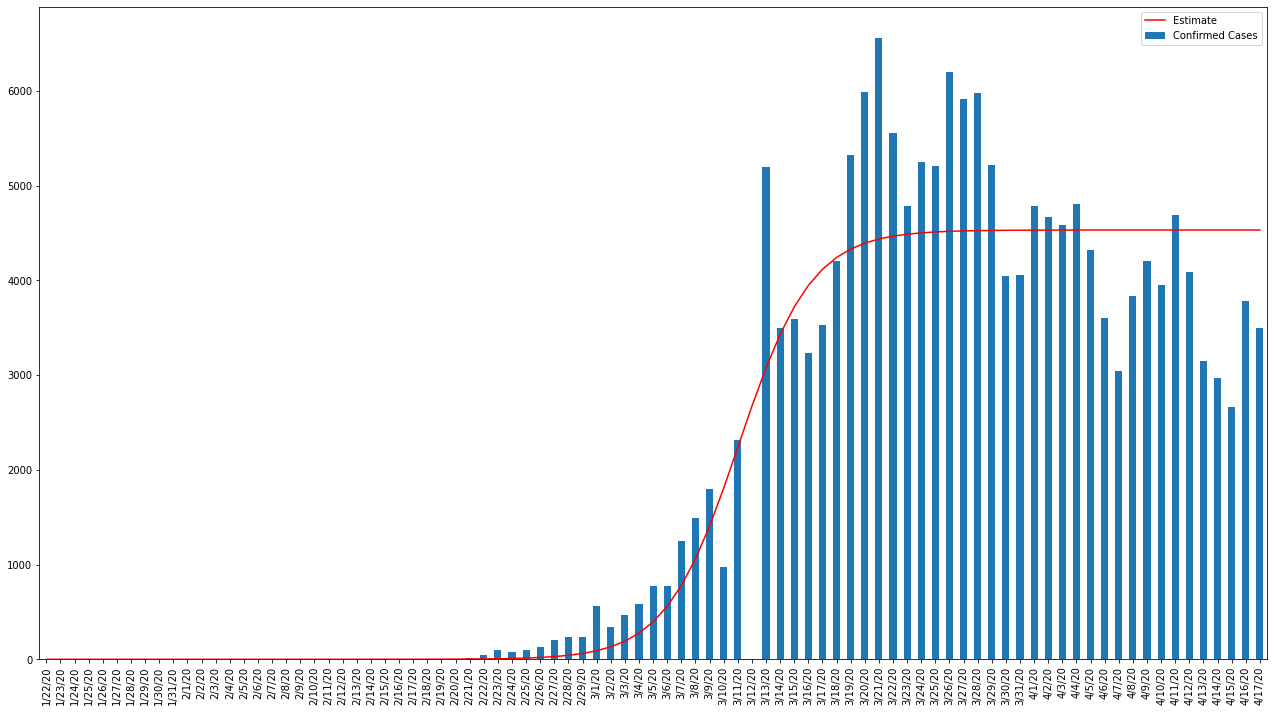

In [25]:
ax = Italy_Data[['Confirmed Cases']].plot(kind='bar', figsize=(22, 12))
estimate = [logistic_function(x, *params) for x in X]
ax.plot(Italy_Data.index, estimate, color='red', label='Estimate')
ax.legend();

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


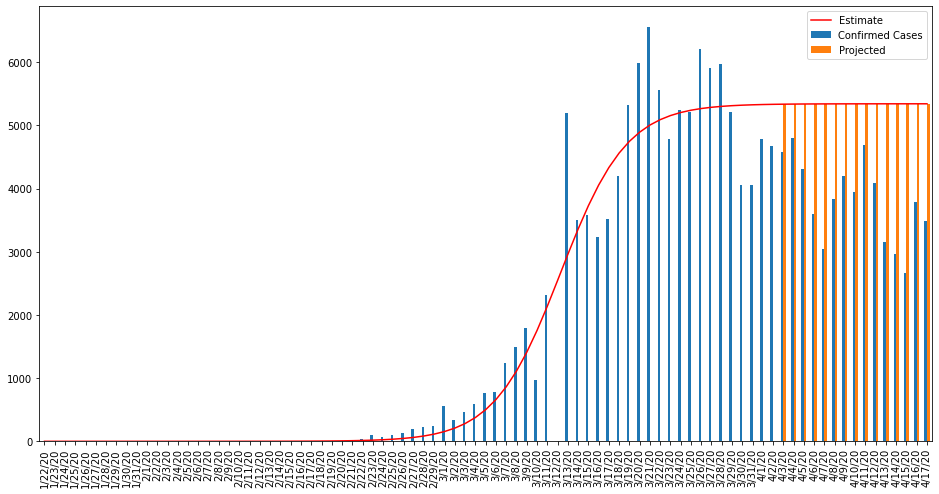

In [26]:
ESTIMATE_DAYS = 15
X_, y_ = X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS]
params_validate, _ = optimize.curve_fit(logistic_function, X_, y_, p0=[max(y), 1, np.median(X)], maxfev = 5000)

# Project zero for all values except for the last ESTIMATE_DAYS
projected = [0] * len(X_) + [logistic_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=Italy_Data.index, name='Projected')
df_ = pd.DataFrame({'Confirmed Cases': Italy_Data['Confirmed Cases'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params_validate) for x in X]
ax.plot(Italy_Data.index, estimate, color='red', label='Estimate')
ax.legend();

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


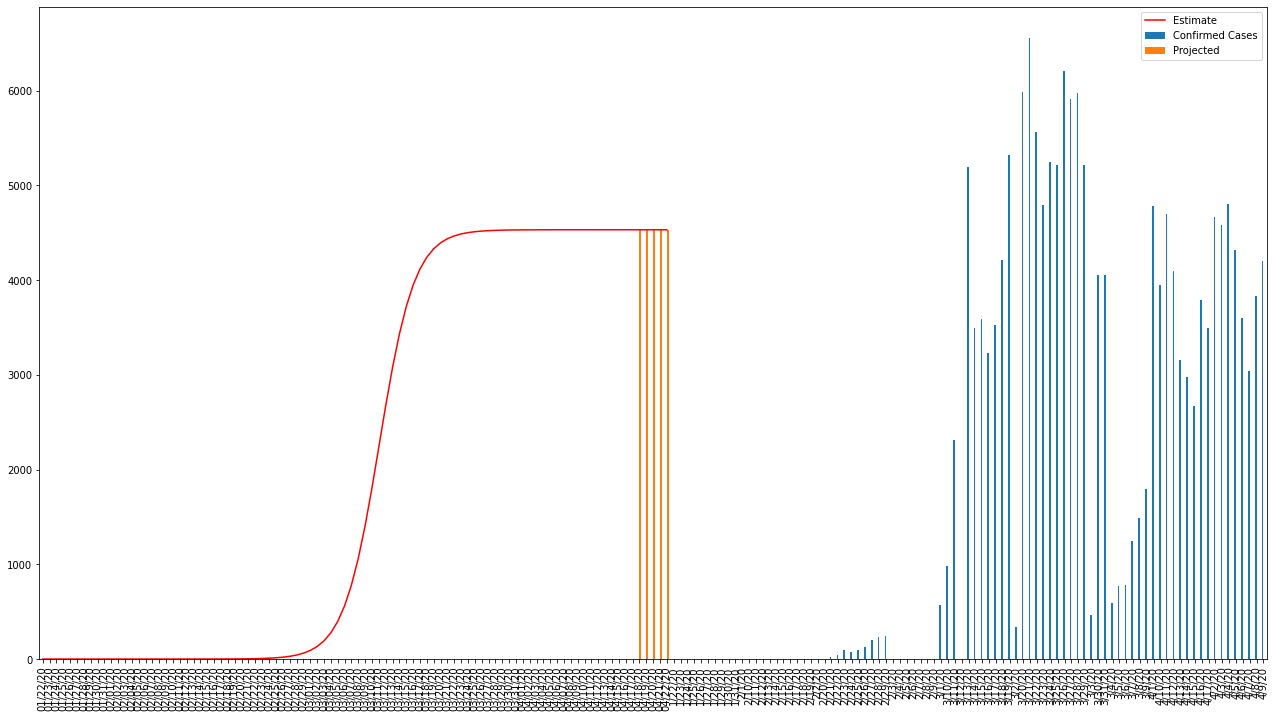

In [27]:
import datetime

FUTURE_DAYS = 5

# Append N new days to our indices
date_format = '%m/%d/%y'
date_range = [datetime.datetime.strptime(date, date_format) for date in Italy_Data.index]
for _ in range(FUTURE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection with the previously estimated parameters
projected = [0] * len(X) + [logistic_function(x, *params) for x in range(len(X), len(X) + FUTURE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed Cases': Italy_Data['Confirmed Cases'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(22, 12))
estimate = [logistic_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Estimate')
ax.legend();